## Zero Bond

In [1]:
import sys
sys.path.append("/Users/kzdb092/Documents/Github/LGM-BFSDE/")
import os, sys; print([p for p in sys.path if os.path.exists(p)])
import pytest
import tensorflow as tf
import pandas as pd
import numpy as np
from scripts.utils.utils.utils import (
    ZeroBond,
    FinanceUtils,
    VisualizationHelper
)
from scripts.trainer.trainer import simulate

T = 16

T_dicts = {
    t: 0 for t in range(1, T)
}
results_t = {
    t: None for t in range(1, T)
}
# Steps per year
nsteps_per_year = 48
# Params for check
for t in range(1, T):
    nsteps = t * nsteps_per_year
    # Fixed params
    simple_params = {
        "T": t,
        "N_steps": nsteps,
        "dim": 1,
        "sigma": 0.01,
        "nsims": 1
    }
    data, _ = simulate(
        T = simple_params["T"], 
        N_steps = simple_params["N_steps"], 
        dim = simple_params["dim"],
        sigma = simple_params["sigma"], 
        nsims = simple_params["nsims"]
    )

    # Get data to process the ZeroBound
    delta_x = data.delta_x_0.values
    xt = data.X_0.values
    dt = data.dt.values
    t_unique = data.dt.unique()
    dict_C = {dt:FinanceUtils.C(dt, sigma_value = 0.01) for dt in t_unique}
    ct = data.apply(lambda x: dict_C[x['dt']], axis = 1)
    nt = ZeroBond.N_tensor(dt,xt,ct)
    # Convert to tensors
    xt = tf.convert_to_tensor(xt, dtype = tf.float64)
    delta_x = tf.convert_to_tensor(delta_x,dtype = tf.float64)
    dt = tf.convert_to_tensor(dt, dtype = tf.float64)
    ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
    T = tf.Variable(np.float64(T), name = 'T', trainable=False)
    # Fix the batch size
    batch_size = int(xt.shape[0] / nsteps)
    # Real values
    v_real = ZeroBond.Z_tensor(xt, dt, T, ct)
    v_real_reshaped = tf.reshape(v_real,(batch_size,nsteps))
    n_tensor = ZeroBond.N_tensor(dt, xt, ct)
    # Derivative:
    xt = tf.Variable(xt, name = 'xn', trainable = True)
    dt = tf.Variable(dt, name = 'tn', trainable = False)
    ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
    with tf.GradientTape() as tape:
        y = ZeroBond.Z_normalized(xt, dt, T, ct)
    grad_df = tape.gradient(y, {'xn':xt})
    grads = grad_df['xn']
    # Simulate - LGM step:
    grads_reshaped = tf.reshape(grads, (batch_size, nsteps))
    xt_reshaped = tf.reshape(xt, (batch_size, nsteps))
    delta_x_reshaped = tf.reshape(delta_x, (batch_size, nsteps))
    # Calculate the MVP
    v = np.ones((batch_size, nsteps)) * np.float64(v_real_reshaped[0, 0])
    for i in range(1, nsteps):
        v[:, i] = (v[:, i - 1] + grads_reshaped[:, i - 1] * delta_x_reshaped[:, i])
    # Calculate errors absolute
    v_real = np.array(tf.reshape(v_real_reshaped, -1))
    v_column = np.array(tf.reshape(v, -1)) * n_tensor.numpy()
    dt_list = np.array(dt)
    df_results = pd.DataFrame(zip(xt.numpy(), v_real, v_column, dt_list, n_tensor.numpy()), columns = ["xt", "v_real","v_est","dt", "n"])
    # Error
    df_results["absolute_error"] = (df_results.v_real - df_results.v_est).abs()
    # Store results
    results_t[t] = df_results.absolute_error.mean()

['/Users/kzdb092/Documents/Github/LGM-BFSDE/notebooks', '/Users/kzdb092/.pyenv/versions/3.11.0/lib/python3.11', '/Users/kzdb092/.pyenv/versions/3.11.0/lib/python3.11/lib-dynload', '/Users/kzdb092/Documents/Github/LGM-BFSDE/.venv/lib/python3.11/site-packages', '/Users/kzdb092/Documents/Github/LGM-BFSDE/']
[MEMORY] Simulation memory usage: 7.152557373046875e-07 Gb
[MEMORY] Simulation memory usage: 1.430511474609375e-06 Gb


2024-03-27 23:18:49.693431: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-03-27 23:18:49.693452: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-03-27 23:18:49.693461: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-03-27 23:18:49.693480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-27 23:18:49.693496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[MEMORY] Simulation memory usage: 2.1457672119140625e-06 Gb
[MEMORY] Simulation memory usage: 2.86102294921875e-06 Gb
[MEMORY] Simulation memory usage: 3.5762786865234375e-06 Gb
[MEMORY] Simulation memory usage: 4.291534423828125e-06 Gb
[MEMORY] Simulation memory usage: 5.0067901611328125e-06 Gb
[MEMORY] Simulation memory usage: 5.7220458984375e-06 Gb
[MEMORY] Simulation memory usage: 6.4373016357421875e-06 Gb
[MEMORY] Simulation memory usage: 7.152557373046875e-06 Gb
[MEMORY] Simulation memory usage: 7.867813110351562e-06 Gb
[MEMORY] Simulation memory usage: 8.58306884765625e-06 Gb
[MEMORY] Simulation memory usage: 9.298324584960938e-06 Gb
[MEMORY] Simulation memory usage: 1.0013580322265625e-05 Gb
[MEMORY] Simulation memory usage: 1.0728836059570312e-05 Gb


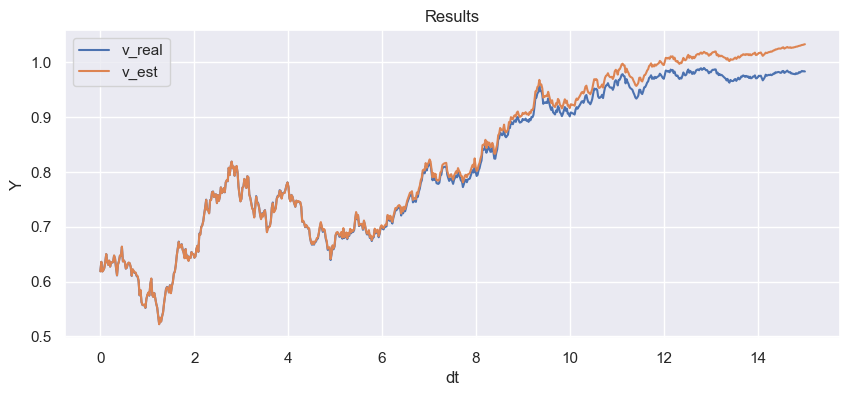

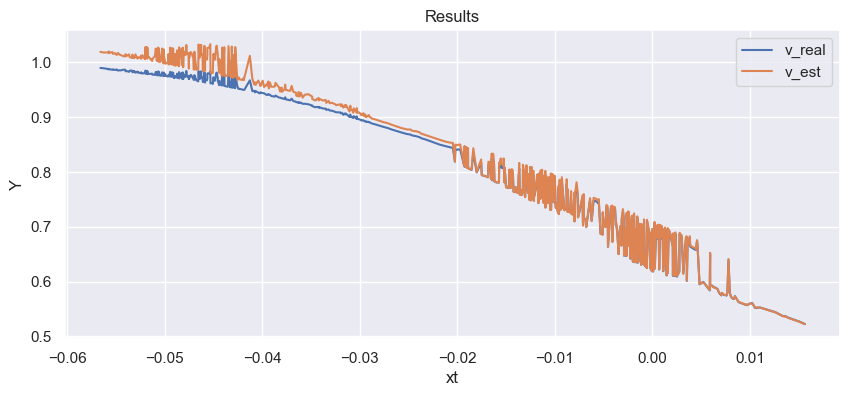

In [2]:
VisualizationHelper.plot_multiple_series(df_results, x = "dt", values_column = ["v_real", "v_est"], xlabel="dt")
VisualizationHelper.plot_multiple_series(df_results, x = "xt", values_column = ["v_real", "v_est"], xlabel="xt")

#### Aggregated result

In [3]:
results_t

{1: 0.0013710241283025545,
 2: 0.0012048184204881708,
 3: 0.0016741990861962725,
 4: 0.0028366973056658164,
 5: 0.0005304846078895373,
 6: 0.0017266655849357776,
 7: 0.006771585190694083,
 8: 0.0018578995123241827,
 9: 0.005165044207265001,
 10: 0.00743565243905256,
 11: 0.005230013234617189,
 12: 0.011159038055525695,
 13: 0.013147478701775692,
 14: 0.009375782496035235,
 15: 0.01251296540829501}

## IRS

![IRS](images/irs/irs.png)
$$
IRS(t, x_t) = \mathcal{N}(x_t, t)A_{1,m}(x_t, t, T)\left(E^{1,m}[S_{i,m}(T_i, T)\vert F(t)]\right)
$$
Donde:
* $A_{i,m} = \tau\sum_{i}^m P(x_t, T_i, T_m)$, con $\tau$ constante para todos los pagos en nuestro caso.
* $\mathcal{N}(x_t, t) = \frac{1}{D(t)}exp(H(t)x_t + \frac{1}{2}H(t)^2\zeta(t))$
* $P(x_t, t, T) = N(x_t, t) E\left[ \frac{1}{N(x_T, T)} \vert F_t\right]$

En este caso el $E^{i,m}[S_{i,m}(T_i, T)\vert F(t)]$ es Martingala, entonces la fórmula queda como:
$$
IRS(t, x_t) = \mathcal{N}(x_t, t)A_{1,m}(x_t, t, T)\left(\frac{P(x_t, t, T_1) - P(x_t, t, T_m)}{A_{1,m}} - K\right)
$$

Reference: https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/blob/main/Lecture%2005-Interest%20Rate%20Products/Lecture%2005-Interest%20Rate%20Products.pdf

$$
IRS(t_0) = (S_{m,n}(t_0) -K)A_{m,n}(t_0)
$$
with:
$$
S_{m,n}(t_0) = \frac{P(t_0, T_m) - P(t_0, T_n)}{A_{m,n}(t_0)}
$$
$t_0$ is the present time

Is $P(t, T_m)$ a Zero-Coupon Bond?

In [4]:
import pytest
import tensorflow as tf
import pandas as pd
import numpy as np
from scripts.utils.utils.utils import (
    IRS,
    ZeroBond,
    FinanceUtils,
    VisualizationHelper
)
from scripts.trainer.trainer import simulate

T = 5
Tm = 10

T_dicts = {
    t: 0 for t in range(1, T)
}
results_t = {
    t: None for t in range(1, T)
}
# Steps per year
nsteps_per_year = 48
# Params for check
nsteps = T * nsteps_per_year
# Fixed params
simple_params = {
    "T": T,
    "N_steps": nsteps,
    "dim": 1,
    "sigma": 0.01,
    "nsims": 1
}
data, _ = simulate(
    T = simple_params["T"], 
    N_steps = simple_params["N_steps"], 
    dim = simple_params["dim"],
    sigma = simple_params["sigma"], 
    nsims = simple_params["nsims"]
)

[MEMORY] Simulation memory usage: 3.5762786865234375e-06 Gb


In [5]:
# Get data to process the ZeroBound
delta_x = data.delta_x_0.values
xt = data.X_0.values
dt = data.dt.values
t_unique = data.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = 0.01) for dt in t_unique}
ct = data.apply(lambda x: dict_C[x['dt']], axis = 1)
nt = ZeroBond.N_tensor(dt,xt,ct)
# Convert to tensors
xt = tf.convert_to_tensor(xt, dtype = tf.float64)
delta_x = tf.convert_to_tensor(delta_x,dtype = tf.float64)
dt = tf.convert_to_tensor(dt, dtype = tf.float64)
ct = tf.convert_to_tensor(ct, dtype = tf.float64)
T = tf.convert_to_tensor(T, dtype = tf.float64)
Tm = tf.convert_to_tensor(Tm, dtype = tf.float64)
# Fix the batch size
batch_size = int(xt.shape[0] / nsteps)
# Real values
v_real = IRS.IRS_test(
    xn = xt, t = dt, Ti = T, Tm = Tm, ct = ct
)
v_real_reshaped = tf.reshape(v_real,(batch_size,nsteps))
n_tensor = ZeroBond.N_tensor(dt, xt, ct)
# Derivative:
xt = tf.Variable(xt, name = 'xn', trainable = True)
dt = tf.Variable(dt, name = 'tn', trainable = False)
ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
T = tf.Variable(np.float64(T), name = 'T', trainable=False, dtype = tf.float64)
Tm = tf.Variable(np.float64(Tm), name = 'Tm', trainable=False, dtype = tf.float64)
with tf.GradientTape() as tape:
    y = IRS.IRS_test_normalized(
        xn = xt, t = dt, Ti = T, Tm = Tm, ct = ct
    )
grad_df = tape.gradient(y, {'xn':xt})
grads = grad_df['xn']
# Custom grads
h = 1e-14
x_p_h = IRS.IRS_test_normalized(
    xn = xt + h, t = dt, Ti = T, Tm = Tm, ct = ct
)
x_m_h = IRS.IRS_test_normalized(
    xn = xt - h, t = dt, Ti = T, Tm = Tm, ct = ct
)
grad_custom = (x_p_h - x_m_h)/(2 * h)
# Simulate - LGM step:
grads_reshaped = tf.reshape(grads, (batch_size, nsteps))
grad_custom_reshaped = tf.reshape(grad_custom, (batch_size, nsteps))
n_tensor_reshaped = tf.reshape(n_tensor, (batch_size, nsteps))
xt_reshaped = tf.reshape(xt, (batch_size, nsteps))
delta_x_reshaped = tf.reshape(delta_x, (batch_size, nsteps))
# Calculate the MVP
v = np.ones((batch_size, nsteps)) * np.float64(v_real_reshaped[0, 0])
v_custom = np.ones((batch_size, nsteps)) * np.float64(v_real_reshaped[0, 0])
for i in range(1, nsteps):
    v[:, i] = (v[:, i - 1] + grads_reshaped[:, i - 1] * delta_x_reshaped[:, i])
    v_custom[:, i] = (v_custom[:, i - 1] + grad_custom_reshaped[:, i - 1] * delta_x_reshaped[:, i])
# Calculate errors absolute
v_real = np.array(tf.reshape(v_real_reshaped, -1))
v_column = np.array(tf.reshape(v, -1)) * n_tensor.numpy()
v_custom = np.array(tf.reshape(v_custom, -1)) * n_tensor.numpy()
dt_list = np.array(dt)
df_results = pd.DataFrame(
    zip(xt.numpy(), v_real, v_column, v_custom, dt_list, n_tensor.numpy(), grads.numpy(), grad_custom.numpy()), 
    columns = ["xt", "v_real","v_est","v_est_custom","dt", "n", "grads", "grads_custom"])
# Error
df_results["absolute_error"] = (df_results.v_real - df_results.v_est).abs()
# Store results
results_t[int(T)] = df_results.absolute_error.mean()

2024-03-27 23:18:59.164402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


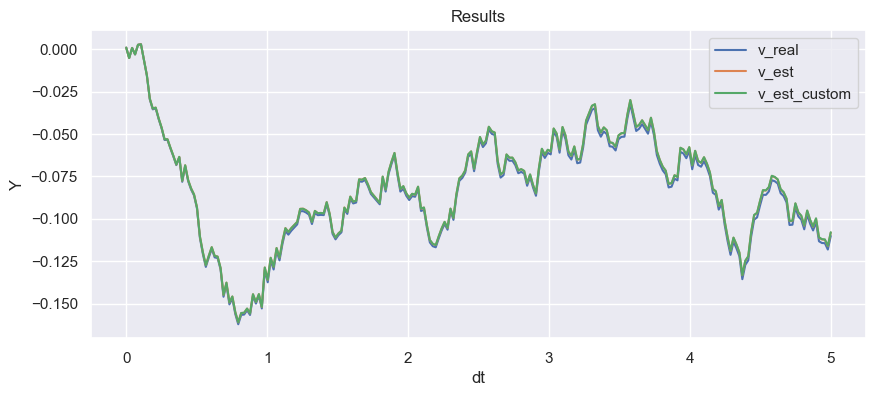

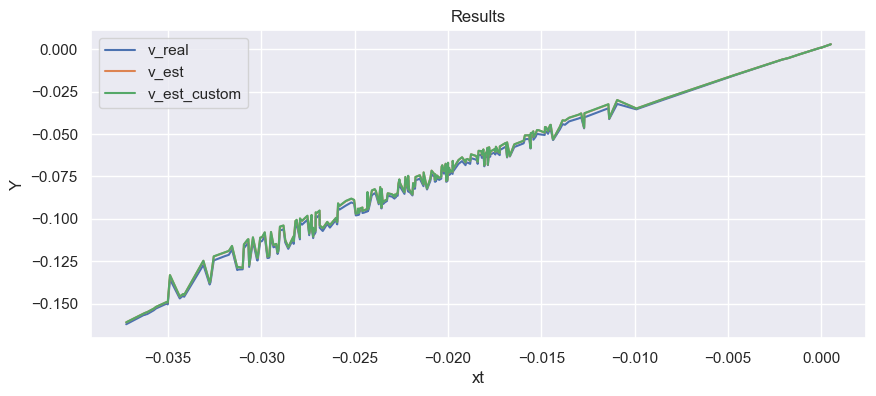

In [6]:
VisualizationHelper.plot_multiple_series(df_results, x = "dt", values_column = ["v_real", "v_est", "v_est_custom"], xlabel="dt")
VisualizationHelper.plot_multiple_series(df_results, x = "xt", values_column = ["v_real", "v_est", "v_est_custom"], xlabel="xt")

# Swaption

\begin{equation*}
    V(x_t, t) = \int_{x_T = -\infty}^{+\infty}(S(T, x_T) - K)^+A(T, x_T)\eta_{x_T\vert x_t}(xT) dxT 
\end{equation*}
where

\begin{equation*}
    \eta \sim \mathcal{N}(x_t, \zeta_T - \zeta_t)
\end{equation*}

\begin{equation*}
    \zeta_t = \int_0^t \sigma^2(t)dt
\end{equation*}

\begin{equation*}
    A(t, x_t) = \sum_{j = 1}^m\tau_j B(t, t_j, x_t)
\end{equation*}

$B(t, t_j, x_t)$ un bono cupón zero llevado desde $t_j$ a $t$ con valor $x_t$.

\begin{equation*}
    S(t, x_t) = \frac{B(t, T, x_t) - B(T, Tm, x_t)}{A(t, x_t)}
\end{equation*}

con $T_m$ fecha del último pago y $T$ fecha de maturity o del primer pago.

### Where this formula comes from?
Under the LGM model we know $V(x_t, t) = \frac{\hat{V}(x_t, t)}{N(x_t, t)}$ is Martingale. With this in mind we can write for any product $V$:
$$
\hat{V}(x_t, t) = N(x_t, t) \int_{X} \frac{\hat{V}(X, T)}{N(X, T)}\cdot \eta_{X\vert x_t}(X) dX
$$
Thus for the Swaption we can write:
$$
\hat{V}^{pay}(x_t, t) = N(x_t, t) \int_{X} \frac{max(\hat{S}(X, T) - K, 0)}{N(X, T)}  \eta_{X\vert x_t}(X)dX
$$

For $\hat{V}(0, 0)$ this means:
$$
\hat{V}^{pay}(0, 0) = \frac{1}{\sqrt{2\pi \zeta_T}} \int_{X} exp(-\frac{1}{2}X^2 / \zeta_T)\cdot \left(- K\tau \sum_{i = 1}^nZ(X, T; T_i) - Z(X, T; T_n) + Z(X, T; T)\right)^{+} dX
$$

and for any $\hat{V}(x_t, t)$ this can be easily generalized as:
$$
\hat{V}^{pay}(x_t, t) = \frac{N(x_t, t)}{\sqrt{2\pi (\zeta_T - \zeta_t)}} \int_{X} exp\left(-\frac{(X - x_t)^2}{2 \cdot (\zeta_T - \zeta_t)}\right)\cdot \left(- K\tau \sum_{i = 1}^nZ(X, T; T_i) - Z(X, T; T_n) + Z(X, T; T)\right)^{+} dX
$$


In [7]:
import sys
if "/Users/kzdb092/Documents/Github/LGM-BFSDE/" not in sys.path:
    sys.path.append("/Users/kzdb092/Documents/Github/LGM-BFSDE/")
import os, sys; print([p for p in sys.path if os.path.exists(p)])
import tensorflow as tf
import pandas as pd
import numpy as np
from scripts.utils.utils.utils import (
    ZeroBond,
    Swaption,
    FinanceUtils,
    VisualizationHelper
)
from scripts.trainer.trainer import simulate

T = 8
Tm = 10

T_dicts = {
    t: 0 for t in range(1, T)
}
results_t = {
    t: None for t in range(1, T)
}
# Steps per year
nsteps_per_year = 48
# Params for check
nsteps = T * nsteps_per_year
# Fixed params
simple_params = {
    "T": T,
    "N_steps": nsteps,
    "dim": 1,
    "sigma": 0.01,
    "nsims": 1
}
data, _ = simulate(
    T = simple_params["T"], 
    N_steps = simple_params["N_steps"], 
    dim = simple_params["dim"],
    sigma = simple_params["sigma"], 
    nsims = simple_params["nsims"]
)

['/Users/kzdb092/Documents/Github/LGM-BFSDE/notebooks', '/Users/kzdb092/.pyenv/versions/3.11.0/lib/python3.11', '/Users/kzdb092/.pyenv/versions/3.11.0/lib/python3.11/lib-dynload', '/Users/kzdb092/Documents/Github/LGM-BFSDE/.venv/lib/python3.11/site-packages', '/Users/kzdb092/Documents/Github/LGM-BFSDE/', '/Users/kzdb092/Documents/Github/LGM-BFSDE', '/Users/kzdb092/Documents/Github/LGM-BFSDE']
[MEMORY] Simulation memory usage: 5.7220458984375e-06 Gb


In [8]:
# Get data to process the ZeroBond
delta_x = data.delta_x_0.values
xt = data.X_0.values
dt = data.dt.values
t_unique = data.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = 0.01) for dt in t_unique}
ct = data.apply(lambda x: dict_C[x['dt']], axis = 1)
nt = ZeroBond.N_tensor(dt,xt,ct)
# Convert to tensors
xt = tf.convert_to_tensor(xt, dtype = tf.float64)
delta_x = tf.convert_to_tensor(delta_x,dtype = tf.float64)
dt = tf.convert_to_tensor(dt, dtype = tf.float64)
ct = tf.convert_to_tensor(ct, dtype = tf.float64)
T = tf.convert_to_tensor(T, dtype = tf.float64)
Tm = tf.convert_to_tensor(Tm, dtype = tf.float64)
# Fix the batch size
batch_size = int(xt.shape[0] / nsteps)
# Real values
v_real = Swaption.Swaption_test(
    xn = xt, t = dt, Ti = T, Tm = Tm, ct = ct
)
v_real_reshaped = tf.reshape(v_real,(batch_size,nsteps))
n_tensor = ZeroBond.N_tensor(dt, xt, ct)
# Derivative:
xt = tf.Variable(xt, name = 'xn', trainable = True)
dt = tf.Variable(dt, name = 'tn', trainable = False)
ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
T = tf.Variable(np.float64(T), name = 'T', trainable=False)
Tm = tf.Variable(np.float64(Tm), name = 'Tm', trainable=False)
with tf.GradientTape() as tape:
    y = Swaption.Swaption_test_normalized(
        xn = xt, t = dt, Ti = T, Tm = Tm, ct = ct
    )
grad_df = tape.gradient(y, {'xn':xt})
grads = grad_df['xn']
# Custom grads
h = 1e-14
x_p_h = Swaption.Swaption_test_normalized(
    xn = xt + h, t = dt, Ti = T, Tm = Tm, ct = ct
)
x_m_h = Swaption.Swaption_test_normalized(
    xn = xt - h, t = dt, Ti = T, Tm = Tm, ct = ct
)
grad_custom = (x_p_h - x_m_h)/(2 * h)
# Simulate - LGM step:
grads_reshaped = tf.reshape(grads, (batch_size, nsteps))
grad_custom_reshaped = tf.reshape(grad_custom, (batch_size, nsteps))
n_tensor_reshaped = tf.reshape(n_tensor, (batch_size, nsteps))
xt_reshaped = tf.reshape(xt, (batch_size, nsteps))
delta_x_reshaped = tf.reshape(delta_x, (batch_size, nsteps))
# Calculate the MVP
v = np.ones((batch_size, nsteps)) * np.float64(v_real_reshaped[0, 0])
v_custom = np.ones((batch_size, nsteps)) * np.float64(v_real_reshaped[0, 0])
for i in range(1, nsteps):
    v[:, i] = (v[:, i - 1] + grads_reshaped[:, i - 1] * delta_x_reshaped[:, i])
    v_custom[:, i] = (v_custom[:, i - 1] + grad_custom_reshaped[:, i - 1] * delta_x_reshaped[:, i])
# Calculate errors absolute
v_real = np.array(tf.reshape(v_real_reshaped, -1))
v_column = np.array(tf.reshape(v, -1)) * n_tensor.numpy()
v_custom = np.array(tf.reshape(v_custom, -1)) * n_tensor.numpy()
dt_list = np.array(dt)
df_results = pd.DataFrame(
    zip(xt.numpy(), v_real, v_column, v_custom, dt_list, n_tensor.numpy(), grads.numpy(), grad_custom.numpy(), ct.numpy()), 
    columns = ["xt", "v_real","v_est","v_est_custom","dt", "n", "grads", "grads_custom", "ct"])
# Error
df_results["absolute_error"] = (df_results.v_real - df_results.v_est).abs()
# Store results
results_t[int(T)] = df_results.absolute_error.mean()

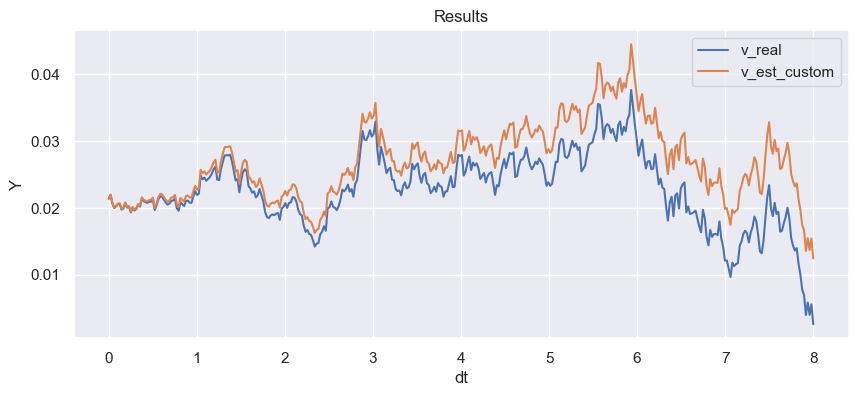

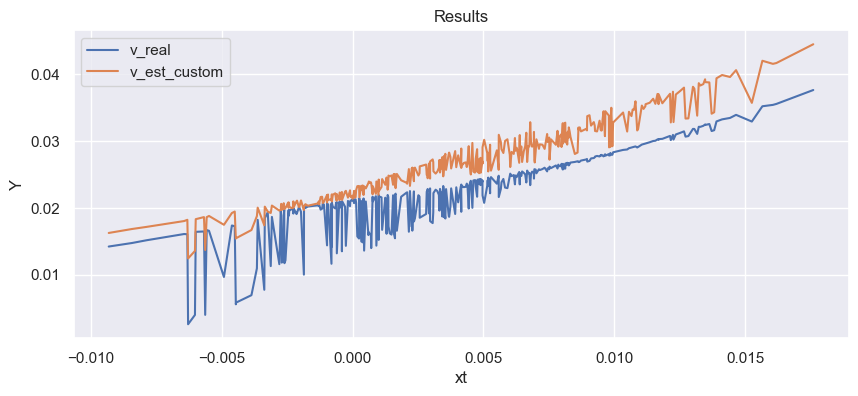

In [9]:
VisualizationHelper.plot_multiple_series(df_results, x = "dt", values_column = ["v_real", "v_est_custom"], xlabel = "dt")
VisualizationHelper.plot_multiple_series(df_results, x = "xt", values_column = ["v_real", "v_est_custom"], xlabel = "xt")

**Strike test**

In [10]:
import sys
if "/Users/kzdb092/Documents/Github/LGM-BFSDE/" not in sys.path:
    sys.path.append("/Users/kzdb092/Documents/Github/LGM-BFSDE/")
import os, sys; print([p for p in sys.path if os.path.exists(p)])
import tensorflow as tf
import pandas as pd
import numpy as np
from scripts.utils.utils.utils import (
    ZeroBond,
    Swaption,
    FinanceUtils,
    VisualizationHelper
)
from scripts.trainer.trainer import simulate

T = 8
Tm = 10

T_dicts = {
    t: 0 for t in range(1, T)
}
results_t = {
    t: None for t in range(1, T)
}
# Steps per year
nsteps_per_year = 48
# Params for check
nsteps = T * nsteps_per_year
# Fixed params
simple_params = {
    "T": T,
    "N_steps": nsteps,
    "dim": 1,
    "sigma": 0.01,
    "nsims": 100
}
data, _ = simulate(
    T = simple_params["T"], 
    N_steps = simple_params["N_steps"], 
    dim = simple_params["dim"],
    sigma = simple_params["sigma"], 
    nsims = simple_params["nsims"]
)

['/Users/kzdb092/Documents/Github/LGM-BFSDE/notebooks', '/Users/kzdb092/.pyenv/versions/3.11.0/lib/python3.11', '/Users/kzdb092/.pyenv/versions/3.11.0/lib/python3.11/lib-dynload', '/Users/kzdb092/Documents/Github/LGM-BFSDE/.venv/lib/python3.11/site-packages', '/Users/kzdb092/Documents/Github/LGM-BFSDE/', '/Users/kzdb092/Documents/Github/LGM-BFSDE', '/Users/kzdb092/Documents/Github/LGM-BFSDE']
[MEMORY] Simulation memory usage: 0.00057220458984375 Gb


In [11]:
# Filter the data
data_filtered = data.loc[
    data.dt == simple_params["T"]
].copy()
# Get the relevant values
delta_x = data_filtered.delta_x_0.values
xt = data_filtered.X_0.values
dt = data_filtered.dt.values
t_unique = data_filtered.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = 0.01) for dt in t_unique}
ct = data_filtered.apply(lambda x: dict_C[x['dt']], axis = 1)
nt = ZeroBond.N_tensor(dt,xt,ct)
# Transform into tensors
xt = tf.convert_to_tensor(xt, dtype = tf.float64)
delta_x = tf.convert_to_tensor(delta_x,dtype = tf.float64)
dt = tf.convert_to_tensor(dt, dtype = tf.float64)
ct = tf.convert_to_tensor(ct, dtype = tf.float64)
T = tf.convert_to_tensor(T, dtype = tf.float64)
Tm = tf.convert_to_tensor(Tm, dtype = tf.float64)
# Derivative:
xt = tf.Variable(xt, name = 'xn', trainable = True)
dt = tf.Variable(dt, name = 'tn', trainable = False)
ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
T = tf.Variable(np.float64(T), name = 'T', trainable=False)
Tm = tf.Variable(np.float64(Tm), name = 'Tm', trainable=False)
with tf.GradientTape() as tape:
    y = Swaption.Swaption_normalized(
        xn = xt, T = T, Tm = Tm, ct = ct
    )
grad_df = tape.gradient(y, {'xn':xt})
grads = grad_df['xn']
# Custom grads
h = 1e-8
x_p_h = Swaption.Swaption_normalized(
    xn = xt + h, T = T, Tm = Tm, ct = ct
)
x_m_h = Swaption.Swaption_normalized(
    xn = xt - h, T = T, Tm = Tm, ct = ct
)
grad_custom = (x_p_h - x_m_h)/(2 * h)